# Biological Interpretability of Deep Neural Network for Cancer Type Prediction

## Preprocessing 

In [32]:
import pickle
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


In [33]:
#local
A = open('./input_data/TCGA_new_pre_second.pckl', 'rb')
[dropped_genes_final, dropped_gene_name, dropped_Ens_id, samp_id_new, diag_name_new,
 project_ids_new] = pickle.load(A)
A.close()

f = open('./input_data/TCGA_new_pre_first.pckl', 'rb')
[_, _, _, _, remain_cancer_ids_ind, remain_normal_ids_ind] = pickle.load(f)
f.close()


In [34]:
dropped_genes_final.head(10)

,TCGA-OR-A5L4-01A-11R-A29S-07,TCGA-OR-A5KX-01A-11R-A29S-07,TCGA-OR-A5JT-01A-11R-A29S-07,TCGA-OR-A5K9-01A-11R-A29S-07,TCGA-OR-A5JV-01A-11R-A29S-07,TCGA-OR-A5KV-01A-11R-A29S-07,TCGA-OR-A5JE-01A-11R-A29S-07,TCGA-OR-A5JC-01A-11R-A29S-07,TCGA-OR-A5LJ-01A-11R-A29S-07,TCGA-OR-A5JW-01A-11R-A29S-07,...,TCGA-AB-2817-03A-01T-0736-13,TCGA-AB-2820-03A-01T-0735-13,TCGA-AB-2836-03A-01T-0736-13,TCGA-AB-2875-03A-01T-0735-13,TCGA-AB-2813-03A-01T-0736-13,TCGA-AB-2828-03A-01T-0734-13,TCGA-AB-2867-03A-01T-0734-13,TCGA-AB-2869-03A-01T-0735-13,TCGA-AB-2874-03A-01T-0735-13,TCGA-AB-2971-03A-01T-0734-13
0,3.593240,3.399946,3.469919,2.821973,2.113599,3.340179,2.882158,3.261231,3.454196,2.908243,...,0.075757,0.417011,0.069219,0.019337,0.143819,0.058231,0.153018,0.190013,0.011547,0.012874
5,0.714444,0.654546,0.873279,0.648664,3.069690,0.455662,1.455837,1.372938,0.762597,0.686878,...,6.033750,3.563423,7.351657,3.986349,7.614381,6.702327,5.354292,3.982174,4.579541,6.171896
6,3.119220,0.136111,0.815520,0.515149,1.088918,0.593629,1.196094,1.424073,0.537714,1.292043,...,2.764164,0.092021,1.377900,0.634325,1.523553,0.306817,0.208830,2.007915,0.152967,0.649813
8,2.464426,2.003238,2.537203,2.874994,2.917765,1.830781,2.021776,1.650647,2.110871,3.203194,...,3.031122,2.336721,2.924426,2.949463,2.541956,2.864531,2.846580,3.209733,2.515867,2.721580
11,1.291976,2.233912,1.894536,1.227373,1.872202,1.670156,1.631871,1.818367,1.680304,1.909422,...,3.070595,3.478873,2.705409,3.213689,2.459187,2.273078,2.684096,3.653754,3.128056,3.262724
13,3.284989,1.212143,3.781889,0.065136,3.425303,1.472745,0.633563,1.472191,1.300726,3.589209,...,1.969967,2.023661,1.915584,2.847401,1.814326,0.334624,2.237953,3.089384,2.672428,2.140357
14,3.526372,2.602193,2.014460,2.501126,2.820626,3.050760,3.369803,2.737441,2.296725,2.602889,...,0.286337,0.039545,0.220263,0.311412,0.352809,0.098903,0.124494,0.713150,0.094858,0.116675
15,0.004483,0.000000,0.015704,0.000000,0.249016,0.005817,0.000000,0.000000,0.061966,0.015653,...,0.006886,0.022540,0.000000,0.010329,0.000000,0.005264,0.006127,0.000000,0.006160,0.054061
22,3.763747,3.206989,4.786515,4.055894,5.299354,3.901138,4.424936,3.896215,3.611985,4.792746,...,4.326744,3.195555,4.850261,3.741599,4.758164,4.368041,3.893956,3.733725,3.521665,4.585919
23,4.014766,7.291967,4.690111,4.444657,4.264578,5.425334,6.274966,6.592201,6.044082,6.056710,...,7.117356,5.974296,5.706885,6.639852,4.898883,5.939179,5.609819,7.466523,5.963444,6.125407


scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 pynndescent==0.5.4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'class' as categorical


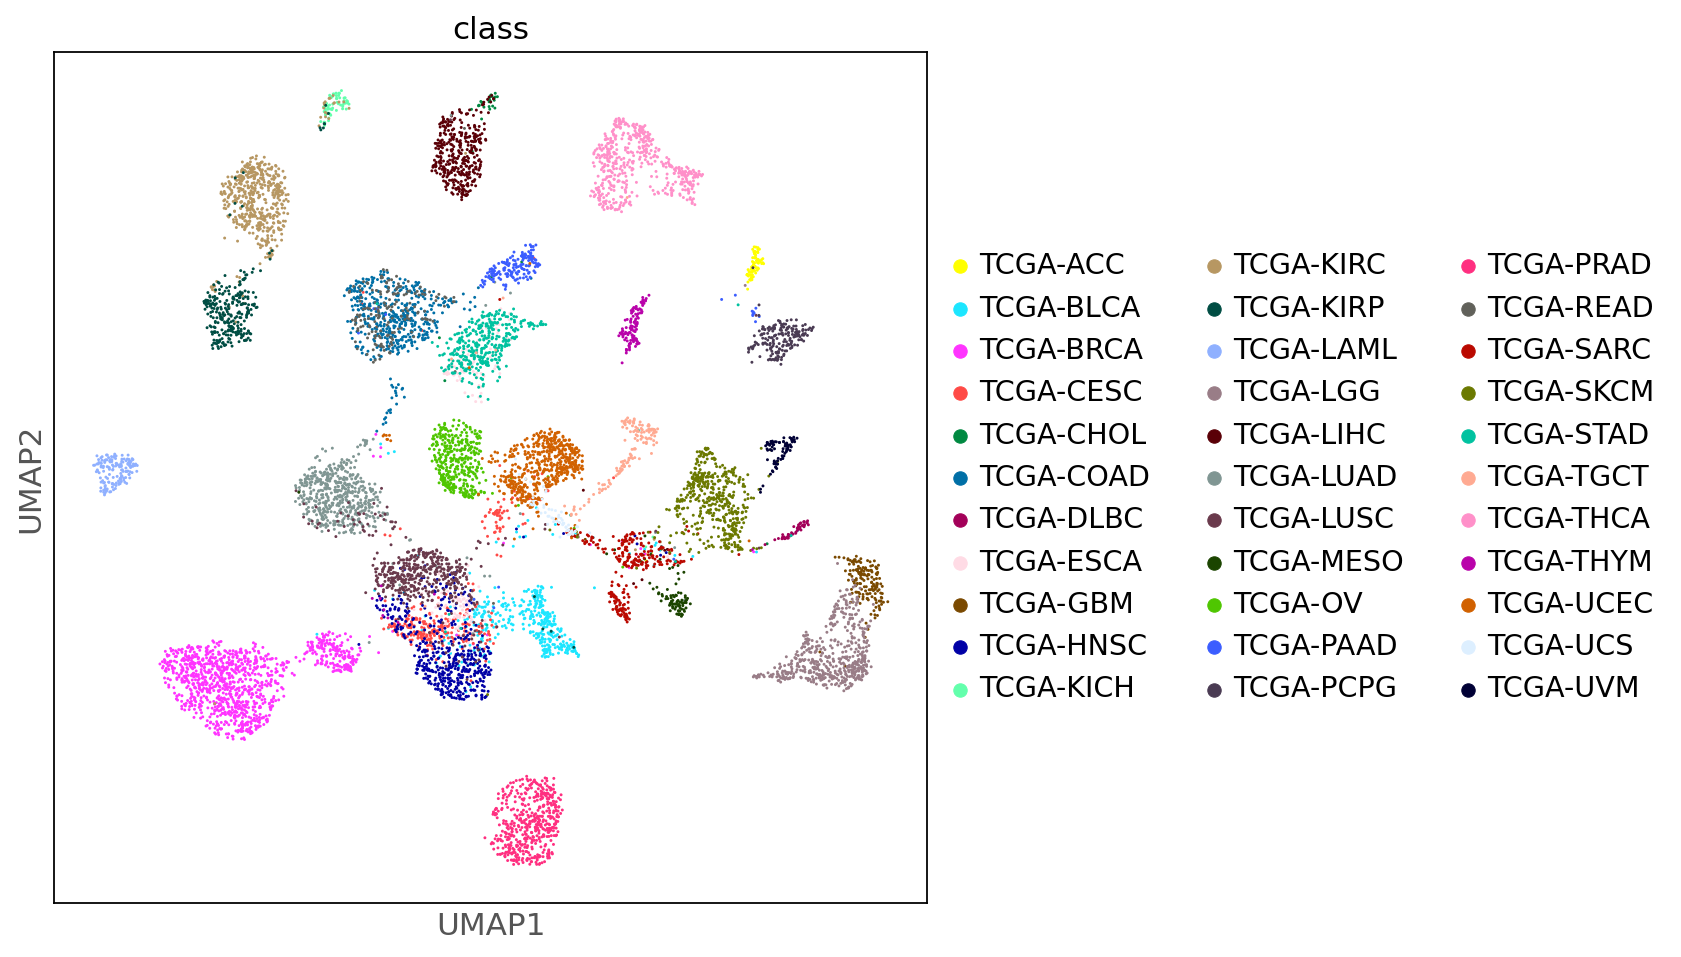

In [ ]:
%matplotlib inline
import scanpy as sc
import anndata
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(7,7))
data = dropped_genes_final.iloc[:,remain_cancer_ids_ind]
data.index = list(dropped_gene_name["external_gene_name"].values)
cancer_classes = []
for i in remain_cancer_ids_ind:
    cancer_classes.append(project_ids_new[i])
sX = anndata.AnnData(data.T)
sX.var_names_make_unique()
sX.var.index.is_unique
sX.obs['class'] = cancer_classes
sc.pp.neighbors(sX)
sc.tl.umap(sX)
sc.pl.umap(sX,color='class',size=7)

In [35]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(project_ids_new)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

X_cancer_samples =dropped_genes_final.iloc[:,remain_cancer_ids_ind].T.values
X_normal_samples = dropped_genes_final.iloc[:,remain_normal_ids_ind].T.values
onehot_encoded_cancer_samples = onehot_encoded[remain_cancer_ids_ind]
onehot_encoded_normal_samples = onehot_encoded[remain_normal_ids_ind]

X_cancer_samples_mat = np.concatenate((X_cancer_samples,np.zeros((len(X_cancer_samples),9))),axis=1)
## add nine zeros to the end of each sample
X_cancer_samples_mat = np.reshape(X_cancer_samples_mat, (-1, 71, 100))

## This line is useful when only one fold training is needed
x_train, x_test, y_train, y_test = train_test_split(X_cancer_samples_mat, onehot_encoded_cancer_samples,
                                                    stratify= onehot_encoded_cancer_samples,
                                                    test_size=0.25, random_state=42)

In [36]:
img_rows, img_cols = len(x_test[0]), len(x_test[0][0])
num_classes = len(y_train[0])
batch_size = 128
epochs = 20
seed = 7
np.random.seed(seed)

input_Xs = X_cancer_samples_mat
y_s = project_ids_new[remain_cancer_ids_ind]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

## MODEL

In [37]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import os
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.5.0
Eager execution: True


In [ ]:
for j in range(1):
    i = 0
    for train, test in kfold.split(input_Xs, y_s):

        input_Xs = input_Xs.reshape(input_Xs.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        input_Xs = input_Xs.astype('float32')

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(y_s)
        # binary encode
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        num_classes = len(onehot_encoded[0])

        
        ## ********* Input Layer 
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=( 71, 100, 1)),
        ## ********* Convolutional layer 
        tf.keras.layers.Conv2D(32, kernel_size=(1, 71), strides=(1, 1),input_shape=input_shape, name='convol',activation='relu'),
        tf.keras.layers.MaxPooling2D(1, 2),
        ## ********* Classification layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax',name='dense_')])
        
        
        
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['categorical_accuracy'])
        callbacks = [EarlyStopping(monitor='categorical_accuracy', patience=3, verbose=0)]
        if i==0:
            model.summary()
            i = i +1
        history = model.fit(input_Xs[train], onehot_encoded[train],
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0, callbacks=callbacks, validation_data=(input_Xs[test], onehot_encoded[test]))
        scores = model.evaluate(input_Xs[test], onehot_encoded[test], verbose=0)
        # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convol (Conv2D)              (None, 71, 30, 32)        2304      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2211968   
_________________________________________________________________
dense_ (Dense)               (None, 33)                4257      
Total params: 2,218,529
Trainable params: 2,218,529
Non-trainable params: 0
_________________________________________________________________
95.40% (+/- 0.23%)


In [38]:
        input_Xs = input_Xs.reshape(input_Xs.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        input_Xs = input_Xs.astype('float32')

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(y_s)
        # binary encode
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        num_classes = len(onehot_encoded[0])

        
        ## ********* Input Layer 
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=( 71, 100, 1)),
        ## ********* Convolutional layer 
        tf.keras.layers.Conv2D(32, kernel_size=(1, 71), strides=(1, 1),input_shape=input_shape, name='convol',activation='relu'),
        tf.keras.layers.MaxPooling2D(1, 2),
        ## ********* Classification layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax',name='dense_')])

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

95.40% (+/- 0.23%)


## Accuracy vs Loss 

In [ ]:
acc =history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

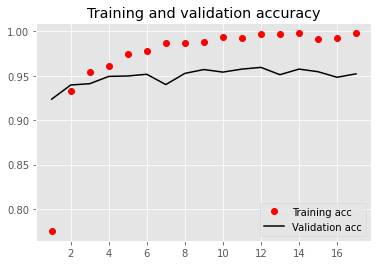

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc',color="red")
plt.plot(epochs, val_acc, 'b', label='Validation acc',color="black")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()



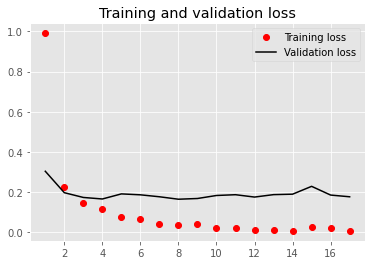

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss',color="red")
plt.plot(epochs, val_loss, 'b', label='Validation loss',color="black")
plt.title('Training and validation loss')
plt.legend()

In [39]:
def write_expression_in_dataframe(dataframe,array,tumor_class):
    dataframe[tumor_class] = array
    return dataframe

In [40]:
def crete_empty_dataset(dropped_genes_final,project_ids_new):
    genes_indx = dropped_genes_final.index.values.tolist()
    columns = list(set(project_ids_new))
    columns.sort()
    new_columns = []
    for item in columns:
        new_columns.append(item)
    rows = list(dropped_gene_name["external_gene_name"].values)
    index_df = list(dropped_gene_name.index)
    df = pd.DataFrame(" ", index =rows, columns = new_columns )
    df.index.name = 'Genes Symbol'
    return df

## Gradient Analysis

In [41]:
def dictionary_for_relevant_genes(y_s,dropped_genes_final,project_ids_new,df,sign_threshold):

    features_per_class = {}
    for i in y_s: 
        features_per_class.update({i : ''})

    genes_indx = dropped_genes_final.index.values.tolist()
    columns = list(set(project_ids_new))
    columns.sort()

    for cancer in (columns):
        genes,scoring_dense = relevant_pathway(dataframe=df,col_filter=cancer,threshold=sign_threshold)
        features_per_class[cancer] = genes
    return features_per_class

In [42]:
def relevant_pathway(dataframe,col_filter,threshold):
    sorted_with_names = dataframe[dataframe[col_filter]>threshold][col_filter].sort_values(ascending=False)
    relevant_genes = list(sorted_with_names.index)
    return relevant_genes,sorted_with_names

In [43]:
import json
def save_json(data,name):
    with open(name, 'w') as fp:
        json.dump(data, fp)
    print(".json file created")

In [44]:
input_Xs = input_Xs.reshape(input_Xs.shape[0], img_rows, img_cols, 1)
input_Xs = input_Xs.astype('float32')
input_shape = (img_rows, img_cols, 1)

features_per_class = {}
for i in y_s:
    features_per_class.update({i : []})

for i in range(len(input_Xs)):
    features_per_class[y_s[i]].append(input_Xs[i])

In [45]:
from gradient import*

In [ ]:
#fill dataset
gradient_based_df = crete_empty_dataset(dropped_genes_final,project_ids_new)
cc = 0 
for cancer in list(gradient_based_df):
    out = call_gradient_given_class(model=model,cancer_class=cancer,cancer_class_idx=0,gradient_selection="vanilla",features_per_class=features_per_class)
    out = out.ravel()[:7091]
    cc +=1
    gradient_based_df = write_expression_in_dataframe(dataframe=gradient_based_df,array=out,tumor_class=cancer)

In [ ]:
gradient_based_df.head(5)

,TCGA-ACC,TCGA-BLCA,TCGA-BRCA,TCGA-CESC,TCGA-CHOL,TCGA-COAD,TCGA-DLBC,TCGA-ESCA,TCGA-GBM,TCGA-HNSC,TCGA-KICH,TCGA-KIRC,TCGA-KIRP,TCGA-LAML,TCGA-LGG,TCGA-LIHC,TCGA-LUAD,TCGA-LUSC,TCGA-MESO,TCGA-OV,TCGA-PAAD,TCGA-PCPG,TCGA-PRAD,TCGA-READ,TCGA-SARC,TCGA-SKCM,TCGA-STAD,TCGA-TGCT,TCGA-THCA,TCGA-THYM,TCGA-UCEC,TCGA-UCS,TCGA-UVM
Genes Symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.043371,0.104373,0.066772,0.094964,0.035934,0.037055,0.019922,0.065202,0.052013,0.080477,0.026376,0.022522,0.030514,0.023255,0.031009,0.053140,0.057151,0.087642,0.069476,0.043388,0.032158,0.031611,0.077728,0.036725,0.048900,0.042896,0.052291,0.034596,0.087146,0.033043,0.064773,0.052138,0.025643
FGR,0.024989,0.063711,0.045712,0.049590,0.047671,0.048878,0.032297,0.039431,0.078601,0.037287,0.037738,0.064673,0.058517,0.067291,0.041743,0.058065,0.097030,0.060599,0.052092,0.036707,0.069852,0.039275,0.080933,0.045827,0.048634,0.075969,0.057748,0.032168,0.038599,0.027795,0.059374,0.036044,0.032688
CFH,0.079770,0.088011,0.111349,0.066892,0.049083,0.046247,0.028562,0.044922,0.129658,0.053060,0.040444,0.078099,0.039988,0.025044,0.084903,0.069133,0.055963,0.096198,0.093372,0.073051,0.045124,0.065753,0.115257,0.054010,0.070169,0.075299,0.051600,0.084191,0.090853,0.099577,0.123398,0.103440,0.119614
GCLC,0.125764,0.091939,0.065718,0.079691,0.147864,0.116916,0.118599,0.101223,0.148137,0.095723,0.044616,0.113797,0.108247,0.134349,0.156384,0.138717,0.079669,0.089849,0.162328,0.084890,0.122875,0.136124,0.154867,0.111008,0.163741,0.145439,0.131863,0.140355,0.045003,0.069230,0.103132,0.116481,0.138549
NIPAL3,0.054387,0.068483,0.053854,0.056330,0.045120,0.058592,0.071881,0.059882,0.064716,0.043731,0.074939,0.055959,0.052019,0.097409,0.137267,0.044690,0.054055,0.049072,0.050402,0.044618,0.048916,0.077397,0.051255,0.056544,0.048029,0.051744,0.053126,0.047707,0.040521,0.035483,0.050805,0.038573,0.050257


In [ ]:
gradient_based_dict = dictionary_for_relevant_genes(y_s,dropped_genes_final,project_ids_new,gradient_based_df,0.8)
save_json(gradient_based_dict, './output_data/dense.json')

.json file created


# NN Interpretation TF-KERAS-VIS
## Activation Maximization Convolutional Layer filter 0

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
#print('Tensorflow recognized {} GPUs'.format(gpus))

In [ ]:
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear

layer_name = 'convol' # The target layer that is the last layer of VGG16.

# This instance constructs new model whose output is replaced to `block5_conv3` layer's output.
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
# This instance modify the model's last activation function to linear one.
replace2linear = ReplaceToLinear()

def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
#from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization import ActivationMaximization
#from tf_keras_vis.activation_maximization.legacy import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress



def maximization(filter_number):

  
  score = CategoricalScore(filter_number)
  activation_maximization = ActivationMaximization(model,
                                                 # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
                                                 model_modifier=[extract_intermediate_layer, replace2linear,],
                                                 clone=False)
  
  activations = activation_maximization(score)
  return normalize(activations.squeeze())


In [ ]:
convol_filter_0 = crete_empty_dataset(dropped_genes_final,project_ids_new)

for i in range(0,33):
  arr = maximization(0).ravel()
  convol_filter_0 = write_expression_in_dataframe(dataframe=convol_filter_0,array=arr[:7091],tumor_class=list(convol_filter_0)[i])

In [ ]:
convol_filter_0.head(5)

,TCGA-ACC,TCGA-BLCA,TCGA-BRCA,TCGA-CESC,TCGA-CHOL,TCGA-COAD,TCGA-DLBC,TCGA-ESCA,TCGA-GBM,TCGA-HNSC,TCGA-KICH,TCGA-KIRC,TCGA-KIRP,TCGA-LAML,TCGA-LGG,TCGA-LIHC,TCGA-LUAD,TCGA-LUSC,TCGA-MESO,TCGA-OV,TCGA-PAAD,TCGA-PCPG,TCGA-PRAD,TCGA-READ,TCGA-SARC,TCGA-SKCM,TCGA-STAD,TCGA-TGCT,TCGA-THCA,TCGA-THYM,TCGA-UCEC,TCGA-UCS,TCGA-UVM
Genes Symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.666667,0.000000,0.25,0.0,0.000000,0.000000,0.0,0.00,1.00,0.75,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.000000,1.000000,0.00,0.0,0.75,0.000000
FGR,0.0,0.25,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.333333,0.25,0.0,0.000000,0.333333,0.0,0.25,0.00,0.00,0.0,0.25,0.0,0.00,1.000000,1.0,0.5,1.000000,0.000000,0.00,0.0,0.00,0.000000
CFH,0.0,0.00,0.0,0.000000,0.0,0.000000,0.75,0.0,0.666667,0.0,0.333333,0.000000,0.25,0.0,0.000000,0.000000,0.5,0.00,0.75,0.00,0.0,0.00,0.5,0.00,0.000000,0.0,0.0,0.000000,0.666667,0.00,0.0,0.00,0.000000
GCLC,0.0,0.50,0.0,0.666667,0.0,0.666667,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.5,0.000000,0.333333,0.0,0.00,0.00,0.25,0.0,0.00,0.0,0.25,0.333333,0.0,0.0,0.000000,0.000000,0.00,0.0,0.25,0.000000
NIPAL3,0.0,0.00,0.0,0.000000,1.0,0.333333,0.25,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,0.333333,0.000000,0.0,0.00,0.25,0.75,0.0,0.00,0.0,0.00,0.333333,0.0,0.0,0.333333,0.333333,0.25,0.0,0.75,0.333333


In [ ]:
convol_filter=_dict = dictionary_for_relevant_genes(y_s,dropped_genes_final,project_ids_new,convol_filter_0,0.8)
save_json(convol_filter, './output_data/convol_filter.json')

.json file created


## Activation Maximization Dense Layer

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
#from tf_keras_vis.activation_maximization.legacy import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

def dense_maximization(layer_idx):
  score = CategoricalScore(layer_idx)
  
  activation_maximization = ActivationMaximization(model,
                                                  model_modifier=replace2linear,
                                                  clone=True) 
  # Generate maximized activation
  activations = activation_maximization(score)
  return normalize(activations.squeeze())

In [ ]:
dense = crete_empty_dataset(dropped_genes_final,project_ids_new)

for i in range(0,33):
  arr = dense_maximization(i).ravel()
  dense = write_expression_in_dataframe(dataframe=dense,array=arr[:7091],tumor_class=list(dense)[i])

In [ ]:
dense.head(5)

,TCGA-ACC,TCGA-BLCA,TCGA-BRCA,TCGA-CESC,TCGA-CHOL,TCGA-COAD,TCGA-DLBC,TCGA-ESCA,TCGA-GBM,TCGA-HNSC,TCGA-KICH,TCGA-KIRC,TCGA-KIRP,TCGA-LAML,TCGA-LGG,TCGA-LIHC,TCGA-LUAD,TCGA-LUSC,TCGA-MESO,TCGA-OV,TCGA-PAAD,TCGA-PCPG,TCGA-PRAD,TCGA-READ,TCGA-SARC,TCGA-SKCM,TCGA-STAD,TCGA-TGCT,TCGA-THCA,TCGA-THYM,TCGA-UCEC,TCGA-UCS,TCGA-UVM
Genes Symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.482759,0.681818,0.104167,0.612245,0.321429,0.840580,0.103448,0.545455,0.703704,0.400000,0.000000,0.500000,0.837209,0.205128,0.526316,0.638889,0.25000,0.833333,0.666667,0.86,0.608696,0.384615,0.681818,0.092308,0.705882,0.142857,0.481481,0.093023,0.479167,0.500000,0.380952,0.230769,0.675676
FGR,0.379310,0.568182,0.208333,0.693878,0.178571,0.869565,0.241379,0.318182,0.740741,0.485714,0.128205,0.785714,0.883721,0.282051,0.368421,0.472222,0.28125,0.694444,0.476190,0.86,0.673913,0.384615,0.568182,0.153846,0.705882,0.285714,0.370370,0.209302,0.375000,0.363636,0.333333,0.307692,0.756757
CFH,0.362069,0.568182,0.250000,0.632653,0.178571,0.913043,0.413793,0.363636,0.703704,0.571429,0.025641,0.607143,0.744186,0.282051,0.421053,0.555556,0.09375,0.777778,0.476190,0.94,0.695652,0.512821,0.659091,0.076923,1.000000,0.285714,0.333333,0.162791,0.354167,0.318182,0.428571,0.333333,0.864865
GCLC,0.431034,0.590909,0.187500,0.693878,0.428571,0.855072,0.241379,0.681818,0.555556,0.742857,0.051282,0.714286,0.720930,0.307692,0.263158,0.388889,0.34375,0.916667,0.619048,0.84,0.586957,0.333333,0.659091,0.153846,0.705882,0.257143,0.555556,0.302326,0.437500,0.409091,0.476190,0.179487,0.756757
NIPAL3,0.327586,0.727273,0.312500,0.632653,0.285714,0.855072,0.241379,0.545455,0.814815,0.600000,0.179487,0.642857,0.744186,0.179487,0.421053,0.250000,0.40625,0.777778,0.714286,0.96,0.760870,0.461538,0.727273,0.061538,0.941176,0.314286,0.481481,0.139535,0.395833,0.500000,0.714286,0.153846,0.891892


In [ ]:
features_per_class = {}
for i in y_s: 
    features_per_class.update({i : []})

In [ ]:
dense_dict = dictionary_for_relevant_genes(y_s,dropped_genes_final,project_ids_new,dense,0.8)
save_json(dense_dict, './output_data/dense.json')

.json file created


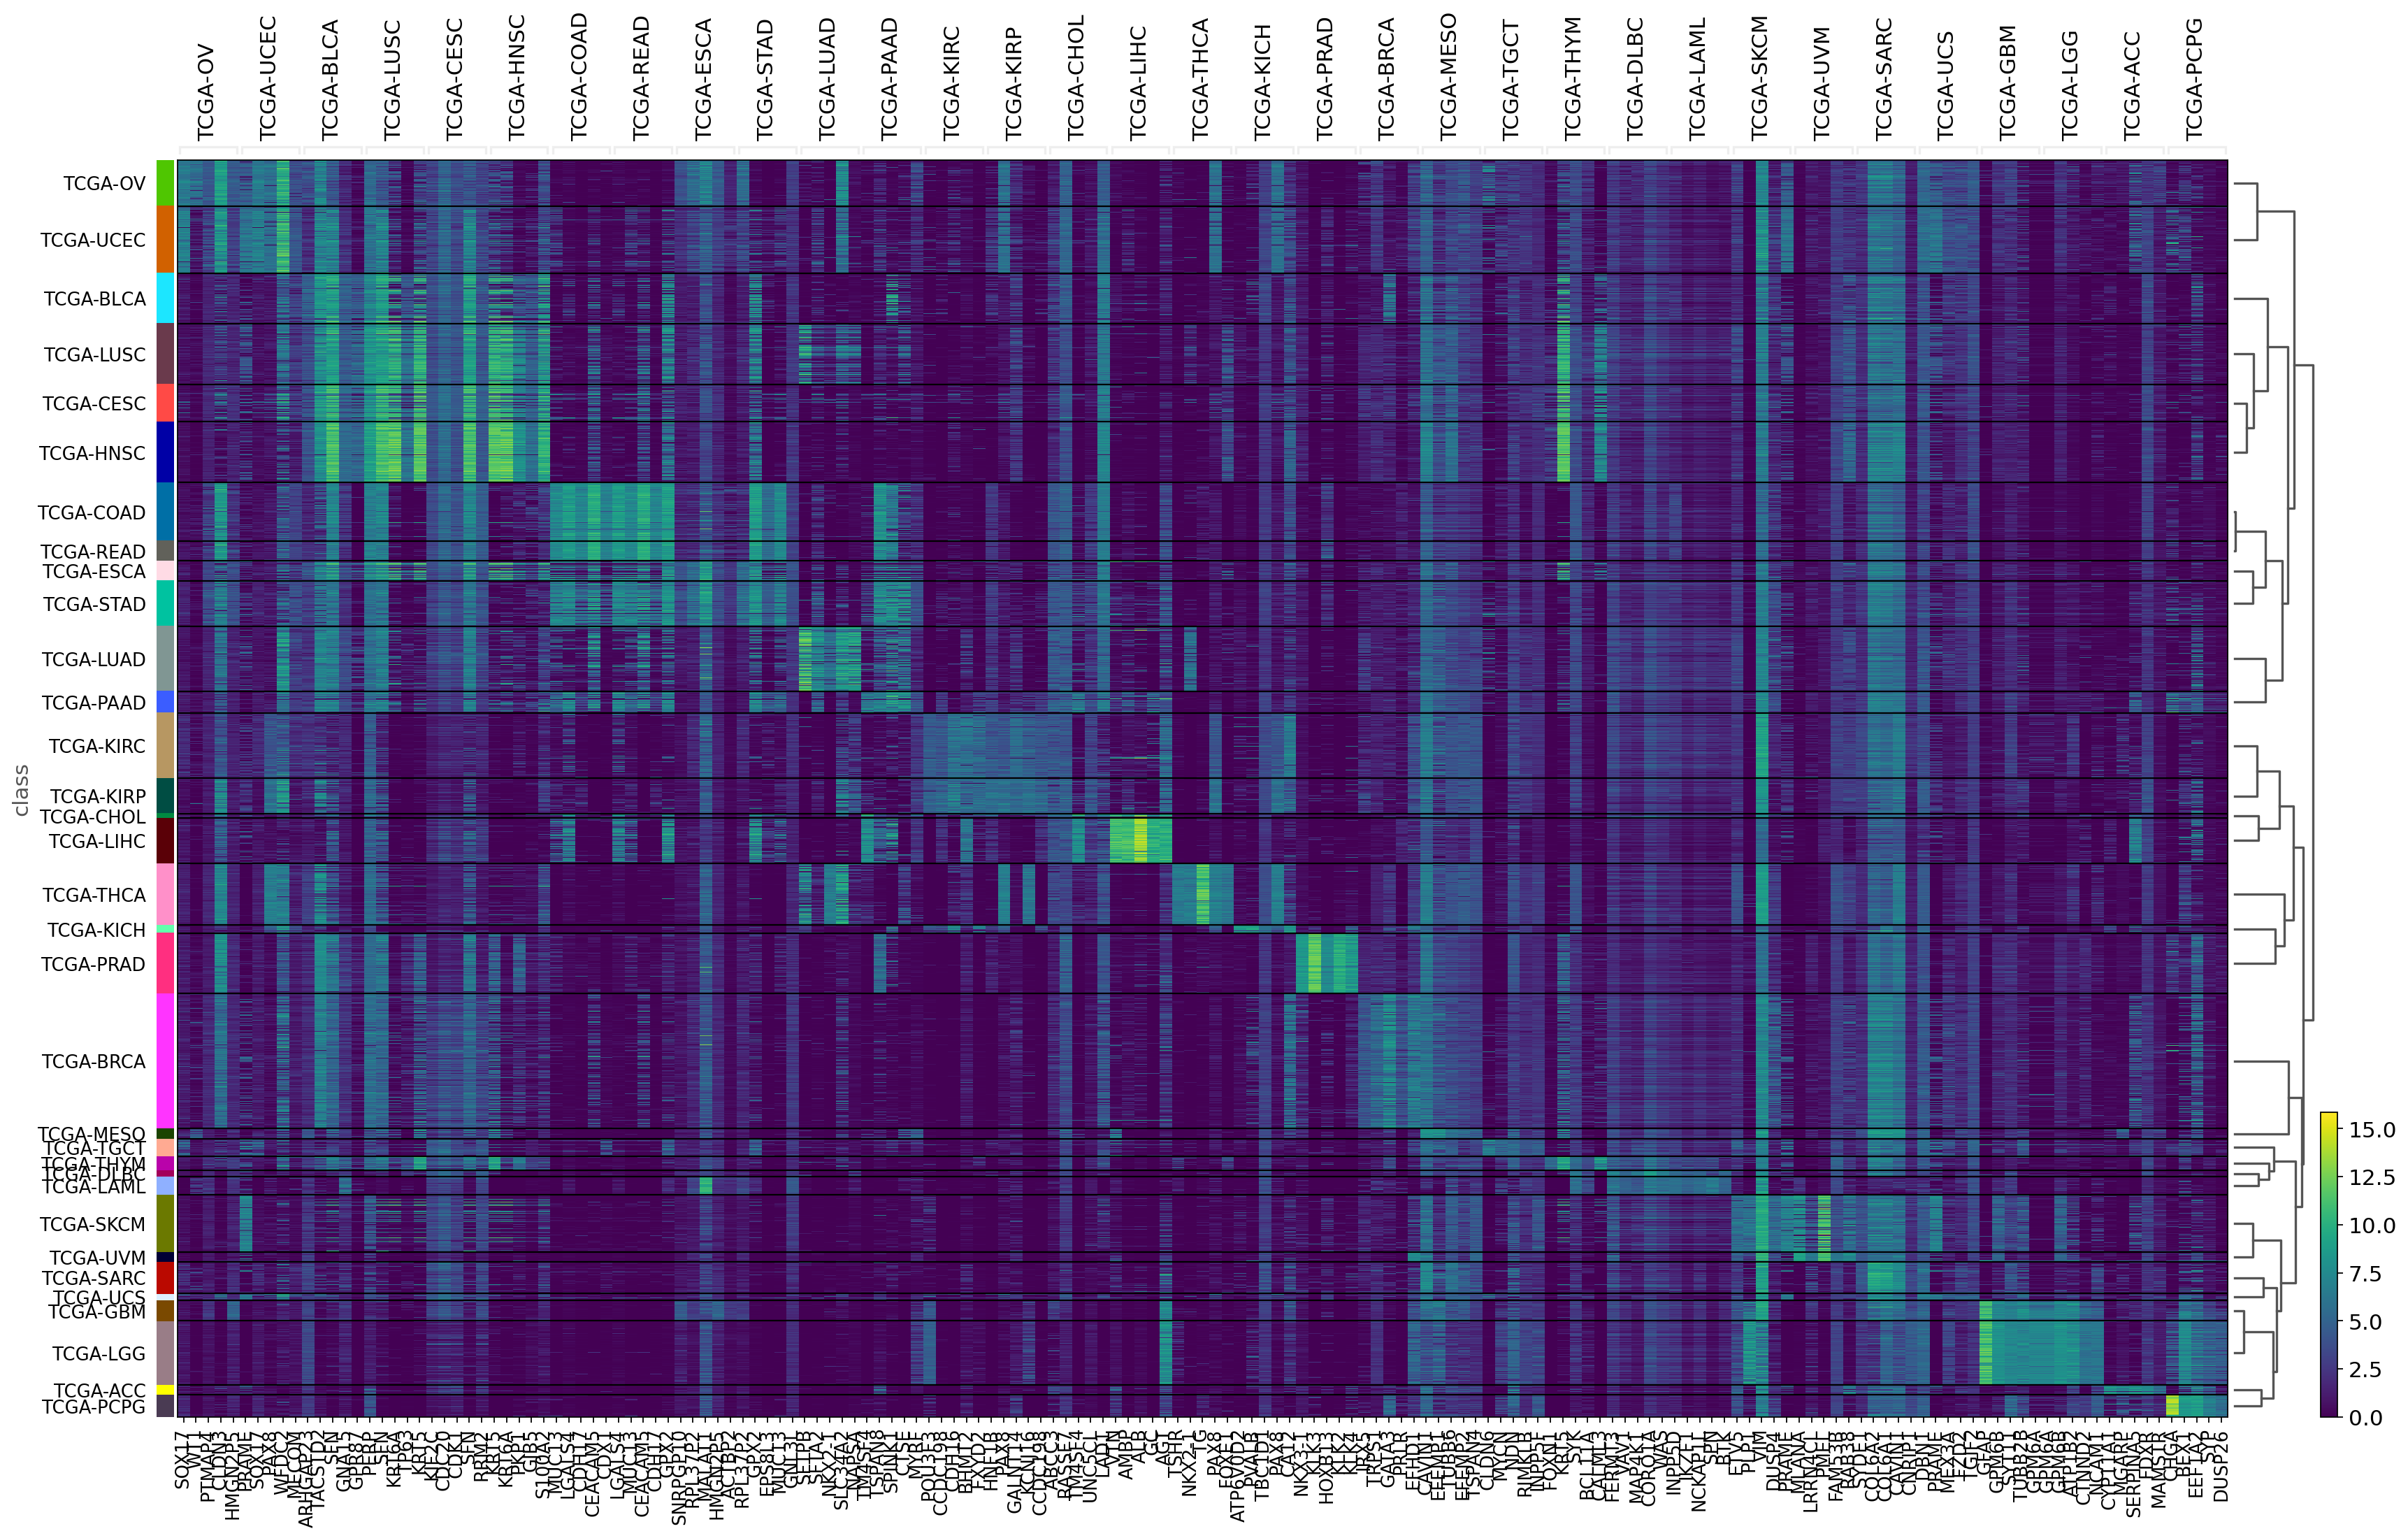

In [ ]:
#Top upregulated genes according to PCA
sc.pp.neighbors(sX)
sX.uns['neighbors']
sc.tl.rank_genes_groups(sX, 'class', method='t-test')
sc.pl.rank_genes_groups_heatmap(sX, n_genes=5, groupby="class",show_gene_labels=True,save=False,figsize=(25,15))

# References

Mostavi, M., Chiu, YC., Huang, Y. et al. Convolutional neural network models for cancer type prediction based on gene expression. BMC Med Genomics 13, 44 (2020). https://doi.org/10.1186/s12920-020-0677-2

Milad Mostavi GitHub Repository: https://github.com/MMostavi/CNNCancerType

tf_keras_vis Documentation: https://github.com/keisen/tf-keras-vis